# Análises Estatísticas – Evasão e Desempenho (Ciência da Computação)

Este notebook contém as análises descritivas, exploratórias e inferenciais, além de modelagem estatística sobre evasão e desempenho.

📌 Estrutura:
1. Perfil dos alunos
2. Trajetória acadêmica
3. Comparação entre grupos
4. Testes estatísticos aplicados
5. Modelagem (Regressão Logística, Análise de Sobrevivência)


In [37]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from lifelines import KaplanMeierFitter, CoxPHFitter

# Função para padronizar colunas
def padronizar_colunas(df):
    return df.rename(
        columns=lambda col: (
            col.strip()
               .lower()
               .replace(" ", "_")
               .replace("ç", "c")
               .replace("ã", "a")
               .replace("á", "a")
        )
    )

# Carregar dados
alunos_ativos = pd.read_csv("alunos_ativos.csv")
alunos_inativos = pd.read_csv("alunos_inativos.csv")
historico = pd.read_csv("historico_escolar.csv")

# Padronizar colunas
alunos_ativos = padronizar_colunas(alunos_ativos)
alunos_inativos = padronizar_colunas(alunos_inativos)
historico = padronizar_colunas(historico)

# Unir datasets de alunos
alunos_ativos["status"] = "ativo"
alunos_inativos["status"] = "inativo"
alunos = pd.concat([alunos_ativos, alunos_inativos], ignore_index=True)

print("Colunas alunos:", alunos.columns.tolist())
print("Colunas historico:", historico.columns.tolist())

# Criar coluna faixa_etaria a partir de data_nascimento (se existir)
if "data_nascimento" in alunos.columns:
    alunos["data_nascimento"] = pd.to_datetime(alunos["data_nascimento"], errors="coerce")
    hoje = pd.to_datetime("today")
    alunos["idade"] = hoje.year - alunos["data_nascimento"].dt.year
    bins = [0, 20, 25, 30, 40, 100]
    labels = ["<20", "20-25", "25-30", "30-40", "40+"]
    alunos["faixa_etaria"] = pd.cut(alunos["idade"], bins=bins, labels=labels)

# Tabela resumida de status
tabela_status = alunos['status'].value_counts().reset_index()
tabela_status.columns = ['Status', 'Quantidade']
tabela_status['Proporcao'] = tabela_status['Quantidade'] / tabela_status['Quantidade'].sum()

print("Resumo de alunos por status:")
display(tabela_status)


Colunas alunos: ['data_nascimento', 'sexo', 'raca', 'estrangeiro', 'nacionalidade', 'naturalidade', 'uf_naturalidade', 'período', 'situacao_atual', 'data_ocorrência', 'estrutura', 'período_ingresso', 'tipo_ingresso', 'imi', 'coeficiente', 'tipo_de_demanda', 'rga_anonimo', 'status']
Colunas historico: ['ano', 'código', 'nome_da_disciplina', 'ch', 'cr', 'tu', 'mf', 'fa', 'sf', 'se', 'rga_anonimo', 'disciplina', 'grupo_de_disciplinas', 'tipo_de_disciplina', 'optativa']
Resumo de alunos por status:


,Status,Quantidade,Proporcao
0,inativo,498,0.693593
1,ativo,220,0.306407


## 1. Perfil dos Alunos
Distribuição por sexo, raça, faixa etária, estado civil e nacionalidade.

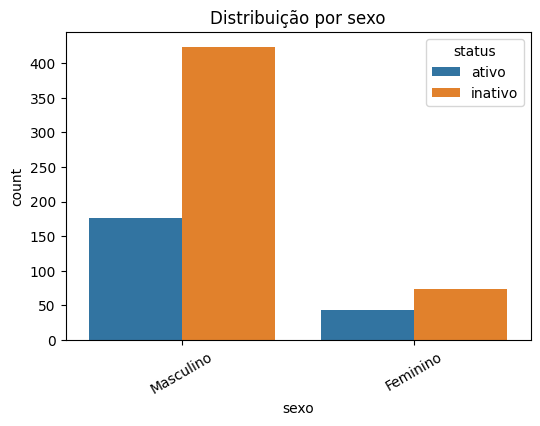

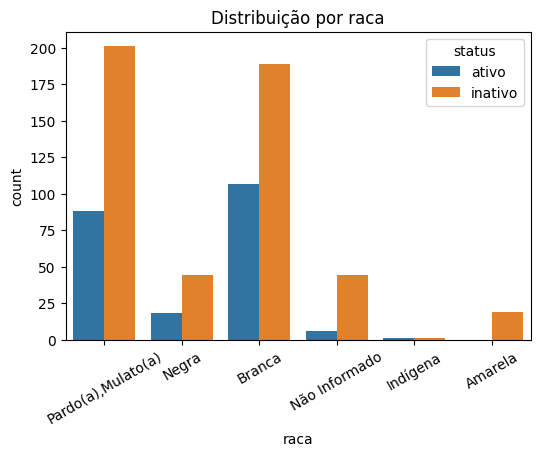

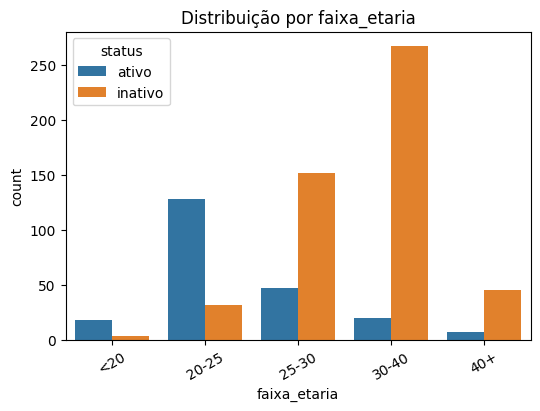

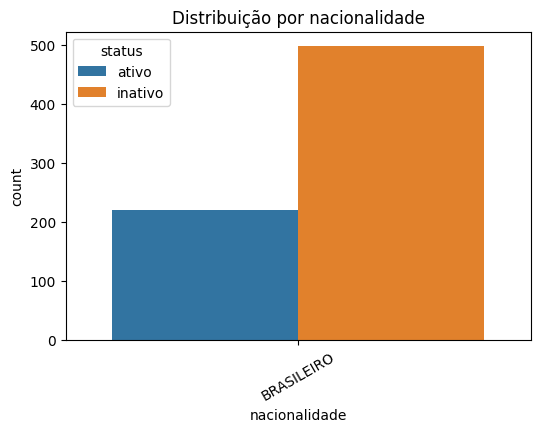


Teste Qui-Quadrado (Sexo x Status)
Qui2=2.574, p-valor=0.1087

Correlação entre coeficiente e evasão:
r=-0.102, p=0.0062


In [38]:
# Perfil dos alunos
for col in ["sexo", "raca", "faixa_etaria", "nacionalidade"]:
    if col in alunos.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(data=alunos, x=col, hue="status")
        plt.title(f"Distribuição por {col}")
        plt.xticks(rotation=30)
        plt.show()

# Qui-quadrado exemplo: evasão x sexo
if "sexo" in alunos.columns:
    tab_sexo = pd.crosstab(alunos["sexo"], alunos["status"])
    chi2, p, _, _ = stats.chi2_contingency(tab_sexo)
    print("\nTeste Qui-Quadrado (Sexo x Status)")
    print(f"Qui2={chi2:.3f}, p-valor={p:.4f}")

# Correlação entre coeficiente e evasão
if "coeficiente" in alunos.columns:
    evadiu = (alunos["status"]=="inativo").astype(int)
    corr, p_corr = stats.pointbiserialr(evadiu, alunos["coeficiente"].fillna(0))
    print("\nCorrelação entre coeficiente e evasão:")
    print(f"r={corr:.3f}, p={p_corr:.4f}")


### 1️⃣ Teste Qui-Quadrado (Sexo x Status)

- Qui2 = 2.574, p-valor = 0.1087
- Como o p-valor > 0.05, não há evidência estatística de associação entre sexo e evasão neste conjunto de dados.
- Em outras palavras: a evasão não depende significativamente do sexo dos alunos.

2️⃣ Correlação entre coeficiente e evasão

- r = -0.102, p = 0.0062
- Correlação negativa fraca: alunos com coeficiente mais alto têm ligeiramente menos chance de evadir.
- Como o p-valor < 0.05, essa correlação é estatisticamente significativa.
- Conclusão: coeficiente de rendimento pode ter algum efeito sobre a evasão, embora seja pequeno.

## 2. Trajetória Acadêmica
Taxa média de aprovação/reprovação por disciplina e identificação de gargalos.

Top 10 Disciplinas Gargalo - Alunos Ativos


status_disciplina,total_alunos,taxa_reprovacao
disciplina,,
Atividades Complementares,10,1.000000
Trabalho de Curso Final,35,1.000000
Informática Aplicada à Educação,20,1.000000
Aprendizagem em Redes Neurais Profundas (Deep Learning),23,0.826087
Cálculo II,144,0.645833
Banco de Dados,154,0.623377
Estrutura de Dados I,205,0.604878
Tópicos Avançados de Inteligência Artificial,5,0.600000
Linguagens Formais e Autômatos,137,0.583942


Top 10 Disciplinas Gargalo - Alunos Inativos


status_disciplina,total_alunos,taxa_reprovacao
disciplina,,
Computadores e Sociedade,4,1.000000
Atividades Complementares,126,0.928571
Introdução à Probalidade e Estatística,33,0.666667
Informática Aplicada à Educação,3,0.666667
Geometria Analítica e Vetorial,632,0.658228
Trabalho de Curso Final,234,0.636752
Estrutura de Dados I,534,0.608614
Cálculo I,669,0.606876
Programação I,871,0.591274


C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\754809743.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_ativos.index, y=top10_ativos["taxa_reprovacao"], palette="Blues_r", ax=axes[0])
C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\754809743.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(top10_ativos.index, rotation=45, ha='right')  # alinhamento horizontal
C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\754809743.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_inativos.index, y=top10_inativos["taxa_reprovacao"], palette="Reds_r", ax=axes[1])
C

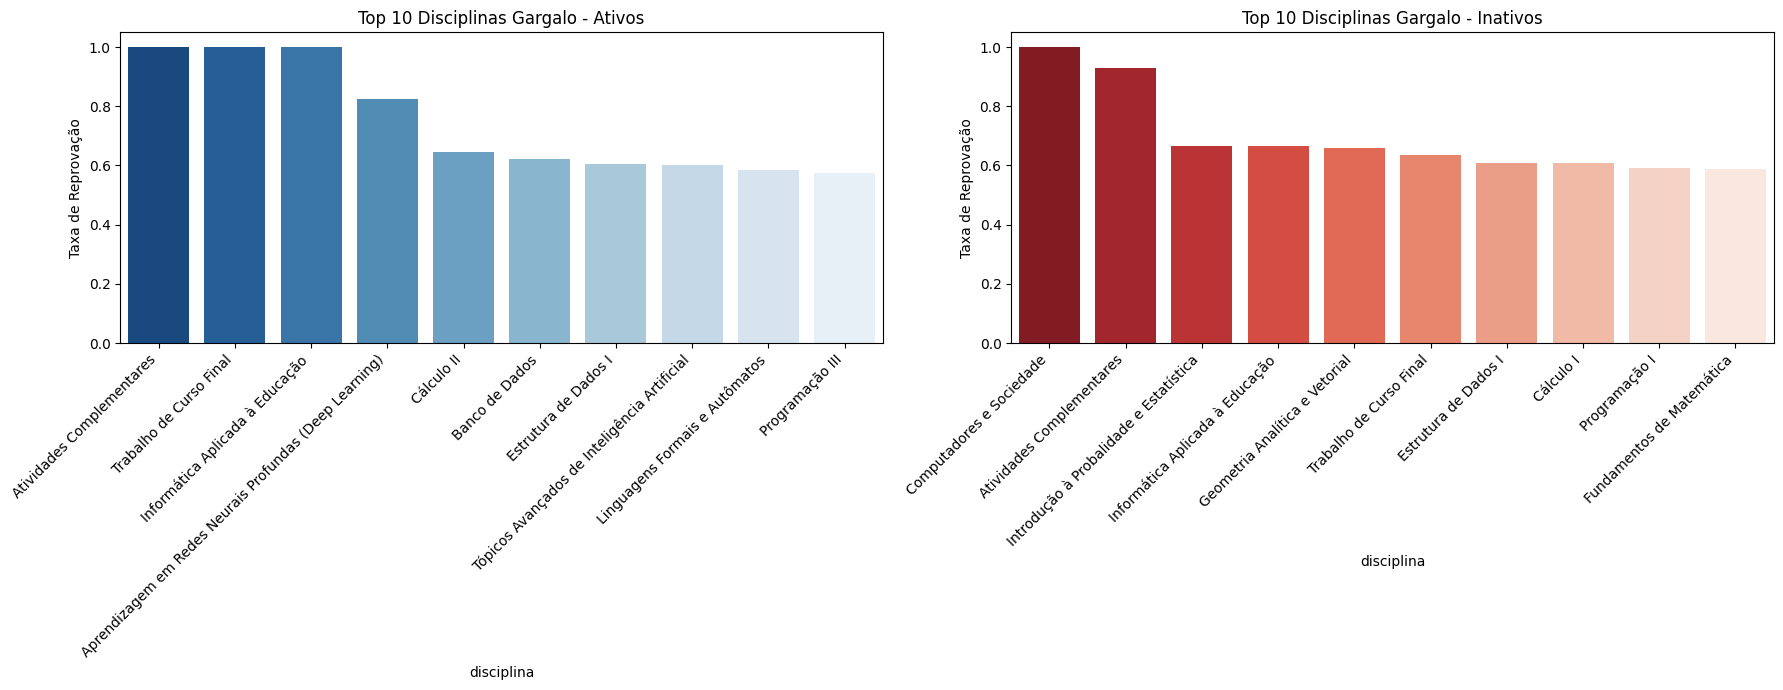

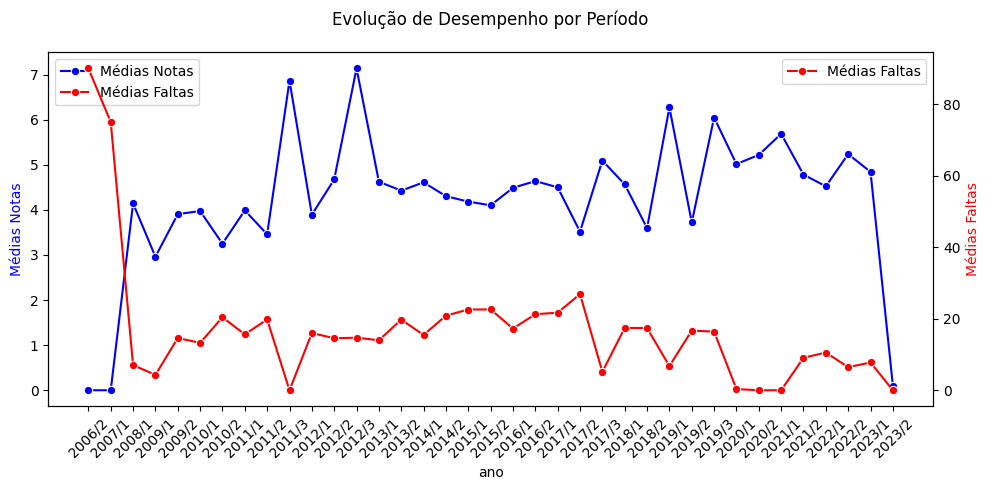

C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\754809743.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=reprovacoes_aluno, x="status", y="n_reprovacoes", palette=["#4C72B0", "#C44E52"])


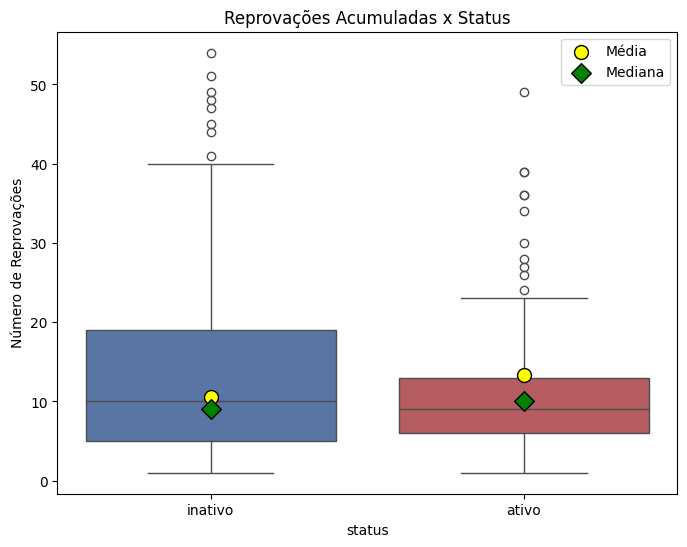

Mann-Whitney U: U=43139.50, p-valor=0.0674


In [39]:

# 0️⃣ Criar coluna de status por disciplina (Aprovado/Reprovado)
historico['status_disciplina'] = np.where(historico['mf'] >= 5, 'Aprovado', 'Reprovado')

# Separar histórico por status do aluno
historico_ativos = historico.merge(alunos[alunos["status"]=="ativo"][["rga_anonimo"]], on="rga_anonimo", how="inner")
historico_inativos = historico.merge(alunos[alunos["status"]=="inativo"][["rga_anonimo"]], on="rga_anonimo", how="inner")

# Calcular taxa de reprovação e quantidade de alunos por disciplina para ativos
status_disciplina_ativos = historico_ativos.groupby(["disciplina", "status_disciplina"]).size().unstack(fill_value=0)
status_disciplina_ativos["total_alunos"] = status_disciplina_ativos.sum(axis=1)
status_disciplina_ativos["taxa_reprovacao"] = status_disciplina_ativos.get("Reprovado",0) / status_disciplina_ativos["total_alunos"]
top10_ativos = status_disciplina_ativos.sort_values("taxa_reprovacao", ascending=False).head(10)

# Calcular taxa de reprovação e quantidade de alunos por disciplina para inativos
status_disciplina_inativos = historico_inativos.groupby(["disciplina", "status_disciplina"]).size().unstack(fill_value=0)
status_disciplina_inativos["total_alunos"] = status_disciplina_inativos.sum(axis=1)
status_disciplina_inativos["taxa_reprovacao"] = status_disciplina_inativos.get("Reprovado",0) / status_disciplina_inativos["total_alunos"]
top10_inativos = status_disciplina_inativos.sort_values("taxa_reprovacao", ascending=False).head(10)

# Mostrar tabelas
print("Top 10 Disciplinas Gargalo - Alunos Ativos")
display(top10_ativos[["total_alunos", "taxa_reprovacao"]])

print("Top 10 Disciplinas Gargalo - Alunos Inativos")
display(top10_inativos[["total_alunos", "taxa_reprovacao"]])

# Gráficos comparativos com nomes das disciplinas centralizados
fig, axes = plt.subplots(1,2, figsize=(18,7))  # figura maior para dar espaço

# Ativos
sns.barplot(x=top10_ativos.index, y=top10_ativos["taxa_reprovacao"], palette="Blues_r", ax=axes[0])
axes[0].set_title("Top 10 Disciplinas Gargalo - Ativos")
axes[0].set_ylabel("Taxa de Reprovação")
axes[0].set_xticklabels(top10_ativos.index, rotation=45, ha='right')  # alinhamento horizontal
axes[0].tick_params(axis='x', labelsize=10)  # tamanho da fonte

# Inativos
sns.barplot(x=top10_inativos.index, y=top10_inativos["taxa_reprovacao"], palette="Reds_r", ax=axes[1])
axes[1].set_title("Top 10 Disciplinas Gargalo - Inativos")
axes[1].set_ylabel("Taxa de Reprovação")
axes[1].set_xticklabels(top10_inativos.index, rotation=45, ha='right')  # alinhamento horizontal
axes[1].tick_params(axis='x', labelsize=10)  # tamanho da fonte

plt.tight_layout()
plt.show()


# 2️⃣ Evolução do desempenho do aluno por período
# Média de notas (mf) e faltas (fa) por ano/período
media_periodo = historico.groupby("ano").agg({"mf":"mean", "fa":"mean"}).reset_index()

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

# Linhas
sns.lineplot(data=media_periodo, x="ano", y="mf", ax=ax1, marker="o", color="blue", label="Médias Notas")
sns.lineplot(data=media_periodo, x="ano", y="fa", ax=ax2, marker="o", color="red", label="Médias Faltas")

# Eixos
ax1.set_ylabel("Médias Notas", color="blue")
ax2.set_ylabel("Médias Faltas", color="red")

# Legenda combinada
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

# Ticks e título
ax1.tick_params(axis='x', rotation=45)
plt.title("Evolução de Desempenho por Período", pad=20)  # pad aumenta distância do título

plt.tight_layout()
plt.show()


# 3️⃣ Relação entre reprovações acumuladas e evasão
# Número de reprovações por aluno
reprovacoes_aluno = historico[historico["mf"] < 5].groupby("rga_anonimo").size().reset_index(name="n_reprovacoes")

# Juntar com status do aluno
reprovacoes_aluno = reprovacoes_aluno.merge(alunos[["rga_anonimo", "status"]], on="rga_anonimo", how="left")

# Boxplot de reprovações por status com médias e medianas
plt.figure(figsize=(8,6))
sns.boxplot(data=reprovacoes_aluno, x="status", y="n_reprovacoes", palette=["#4C72B0", "#C44E52"])

# Adicionar média
medias = reprovacoes_aluno.groupby("status")["n_reprovacoes"].mean()
for i, status in enumerate(medias.index):
    plt.scatter(i, medias[status], color='yellow', edgecolor='black', zorder=10, s=100, label='Média' if i==0 else "")

# Adicionar mediana
medianas = reprovacoes_aluno.groupby("status")["n_reprovacoes"].median()
for i, status in enumerate(medianas.index):
    plt.scatter(i, medianas[status], color='green', edgecolor='black', zorder=10, s=100, marker='D', label='Mediana' if i==0 else "")

plt.title("Reprovações Acumuladas x Status")
plt.ylabel("Número de Reprovações")
plt.legend()
plt.show()

# Teste estatístico (Mann-Whitney U) para diferenças entre ativos e inativos
ativo = reprovacoes_aluno[reprovacoes_aluno["status"]=="ativo"]["n_reprovacoes"]
inativo = reprovacoes_aluno[reprovacoes_aluno["status"]=="inativo"]["n_reprovacoes"]
u_stat, p_val = stats.mannwhitneyu(ativo, inativo)
print(f"Mann-Whitney U: U={u_stat:.2f}, p-valor={p_val:.4f}")

## 3. Comparação entre grupos
Exemplo: coeficiente médio entre evadidos e concluintes (t-Teste).

C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\3367291032.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=alunos, x="sexo", y="coeficiente", palette="Pastel1")


ANOVA - CR por Sexo:
               sum_sq     df         F    PR(>F)
C(sexo)      0.255819    1.0  0.038244  0.845009
Residual  4789.397707  716.0       NaN       NaN


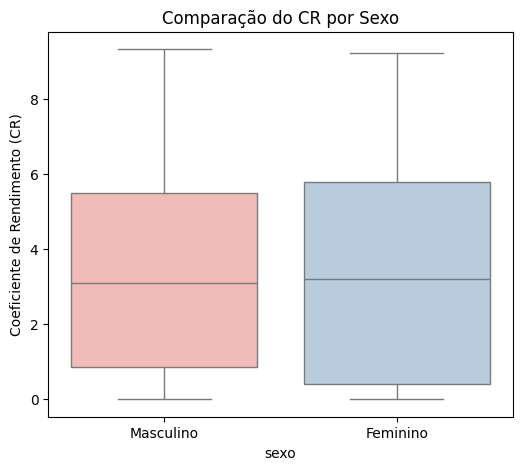

ANOVA - CR por Raça:
               sum_sq     df         F    PR(>F)
C(raca)     42.985793    5.0  1.289574  0.266392
Residual  4746.667732  712.0       NaN       NaN


C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\3367291032.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=alunos, x="raca", y="coeficiente", palette="Pastel2")


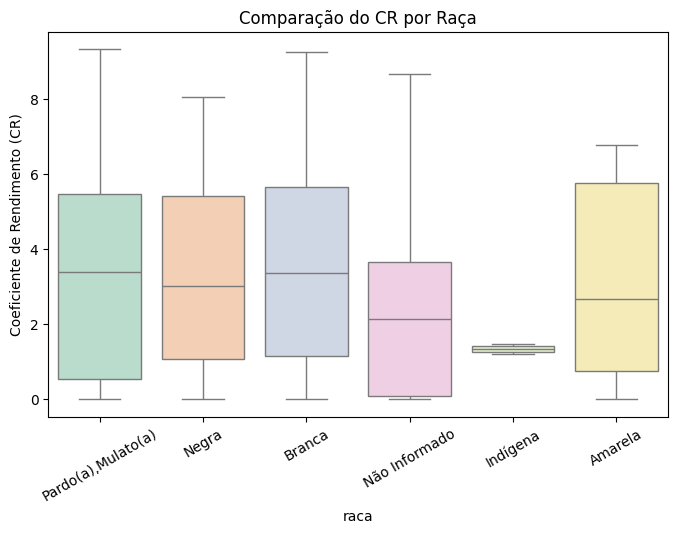

C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\3367291032.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
C:\Users\gabri\AppData\Local\Temp\ipykernel_35740\3367291032.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


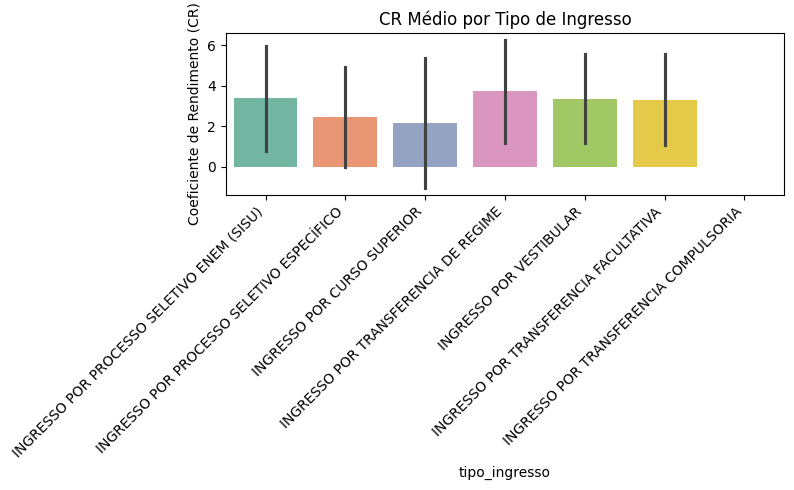

Teste Qui-Quadrado (Evasão x Tipo de Ingresso):
Qui2=105.256, p-valor=0.0000


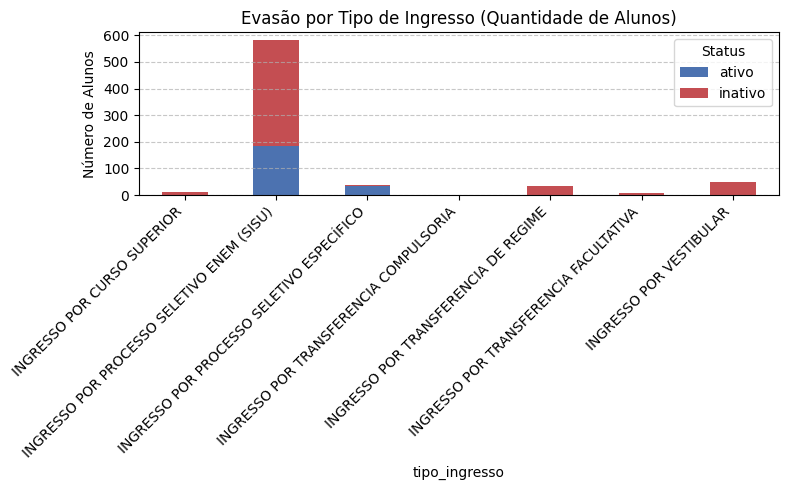

In [40]:
# 1️⃣ CR por sexo
anova_sexo = smf.ols('coeficiente ~ C(sexo)', data=alunos).fit()
print("ANOVA - CR por Sexo:")
print(sm.stats.anova_lm(anova_sexo, typ=2))

plt.figure(figsize=(6,5))
sns.boxplot(data=alunos, x="sexo", y="coeficiente", palette="Pastel1")
plt.title("Comparação do CR por Sexo")
plt.ylabel("Coeficiente de Rendimento (CR)")
plt.show()

# 2️⃣ CR por raça
anova_raca = smf.ols('coeficiente ~ C(raca)', data=alunos).fit()
print("ANOVA - CR por Raça:")
print(sm.stats.anova_lm(anova_raca, typ=2))

plt.figure(figsize=(8,5))
sns.boxplot(data=alunos, x="raca", y="coeficiente", palette="Pastel2")
plt.title("Comparação do CR por Raça")
plt.ylabel("Coeficiente de Rendimento (CR)")
plt.xticks(rotation=30)
plt.show()

# 3️⃣ CR por tipo de ingresso
plt.figure(figsize=(8,5))
sns.barplot(
    data=alunos, 
    x="tipo_ingresso", 
    y="coeficiente", 
    ci="sd",  # ci="sd" mostra desvio padrão
    palette="Set2"
)
plt.ylabel("Coeficiente de Rendimento (CR)")
plt.title("CR Médio por Tipo de Ingresso")
plt.xticks(rotation=45, ha='right')  # centraliza os rótulos
plt.tight_layout()
plt.show()

# 4️⃣ Evasão por tipo de ingresso (ENEM, transferência, cotas)
tab_ingresso = pd.crosstab(alunos["tipo_ingresso"], alunos["status"])
chi2, p, _, _ = stats.chi2_contingency(tab_ingresso)
print("Teste Qui-Quadrado (Evasão x Tipo de Ingresso):")
print(f"Qui2={chi2:.3f}, p-valor={p:.4f}")

# Gráfico de quantidade de alunos
ax = tab_ingresso.plot(kind="bar", stacked=True, figsize=(8,5), color=["#4C72B0","#C44E52"])

plt.title("Evasão por Tipo de Ingresso (Quantidade de Alunos)")
plt.ylabel("Número de Alunos")
plt.xticks(rotation=45, ha='right')  # centraliza os rótulos

# Adicionar linhas de grade horizontais
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar ticks do eixo Y de 100 em 100
max_y = tab_ingresso.sum(axis=1).max()
plt.yticks(range(0, int(max_y)+101, 100))

plt.legend(title="Status")
plt.tight_layout()
plt.show()

## 4. Associação entre variáveis categóricas (Qui-quadrado)



=== Evasão x Sexo ===


status,ativo,inativo
sexo,,
Feminino,44,74
Masculino,176,424


Qui-quadrado: χ2=2.574, p-valor=0.1087, df=1


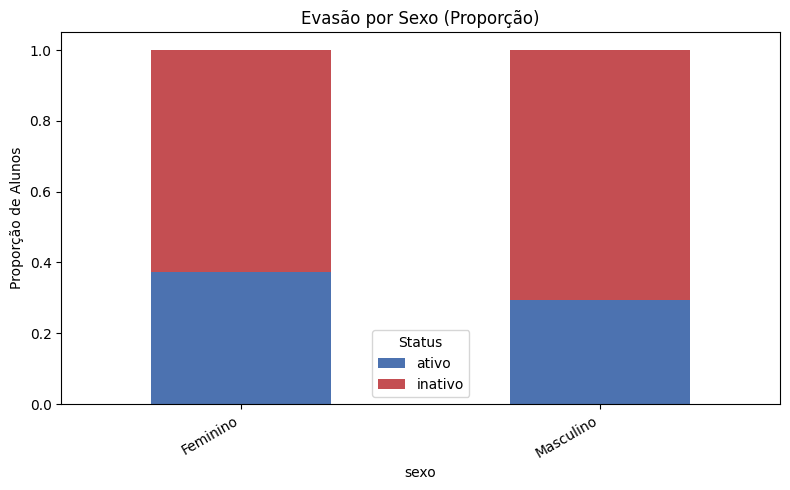


=== Evasão x Raca ===


status,ativo,inativo
raca,,
Amarela,0,19
Branca,107,189
Indígena,1,1
Negra,18,44
Não Informado,6,44
"Pardo(a),Mulato(a)",88,201


Qui-quadrado: χ2=21.227, p-valor=0.0007, df=5


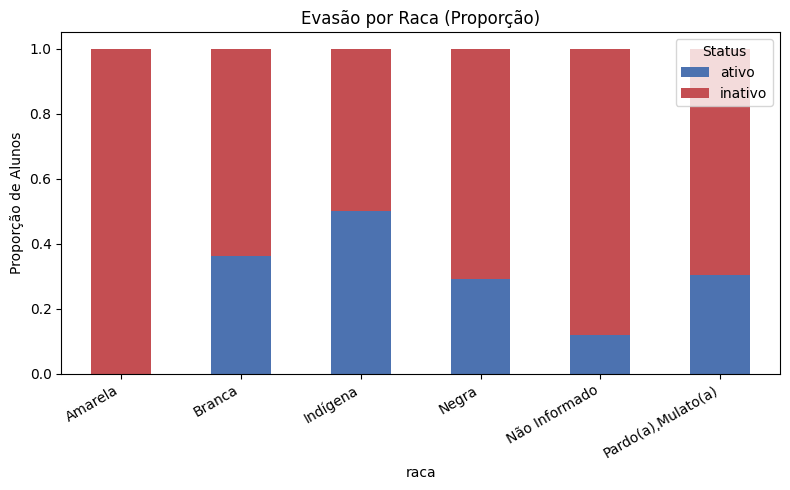


=== Evasão x Tipo_ingresso ===


status,ativo,inativo
tipo_ingresso,,
INGRESSO POR CURSO SUPERIOR,2,9
INGRESSO POR PROCESSO SELETIVO ENEM (SISU),184,398
INGRESSO POR PROCESSO SELETIVO ESPECÍFICO,34,3
INGRESSO POR TRANSFERENCIA COMPULSORIA,0,1
INGRESSO POR TRANSFERENCIA DE REGIME,0,33
INGRESSO POR TRANSFERENCIA FACULTATIVA,0,6
INGRESSO POR VESTIBULAR,0,48


Qui-quadrado: χ2=105.256, p-valor=0.0000, df=6


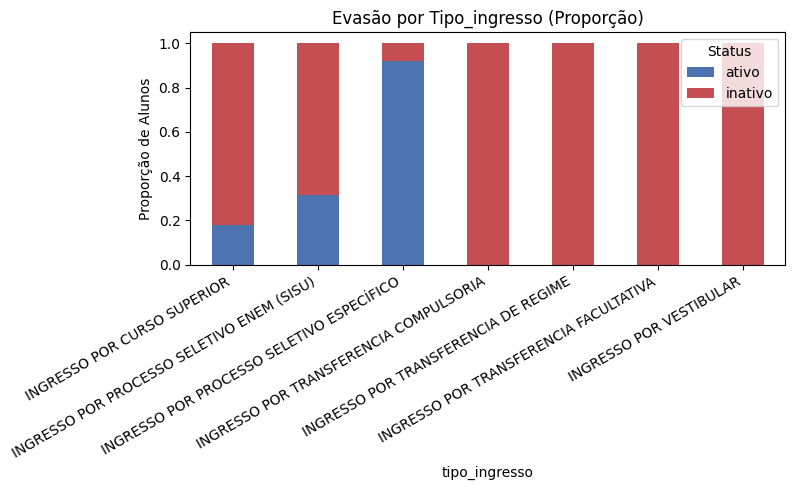

In [41]:
# Lista de variáveis categóricas para testar
categoricas = ["sexo", "raca", "tipo_ingresso", "estado_civil"]

for var in categoricas:
    if var in alunos.columns:
        print(f"\n=== Evasão x {var.capitalize()} ===")
        
        # Tabela cruzada
        tab = pd.crosstab(alunos[var], alunos["status"])
        display(tab)
        
        # Teste Qui-quadrado
        chi2, p, dof, expected = stats.chi2_contingency(tab)
        print(f"Qui-quadrado: χ2={chi2:.3f}, p-valor={p:.4f}, df={dof}")
        
        # Gráfico de proporção
        tab_norm = tab.div(tab.sum(axis=1), axis=0)
        ax = tab_norm.plot(kind="bar", stacked=True, figsize=(8,5), color=["#4C72B0","#C44E52"])
        plt.ylabel("Proporção de Alunos")
        plt.title(f"Evasão por {var.capitalize()} (Proporção)")
        plt.xticks(rotation=30, ha='right')
        plt.legend(title="Status")
        plt.tight_layout()
        plt.show()


## 5. Correlações
Exemplo: correlação entre coeficiente e faltas.

Correlação Pearson entre Faltas e CR:
r = -0.093, p-valor = 0.0130

Correlação Spearman entre Faltas e CR:
rho = -0.022, p-valor = 0.5516


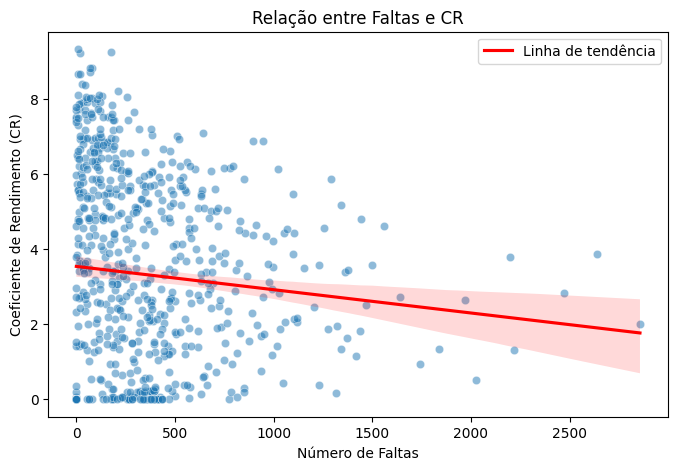

In [42]:
# Agrupar histórico por aluno
faltas_aluno = historico.groupby("rga_anonimo")["fa"].sum().reset_index()
cr_aluno = alunos[["rga_anonimo", "coeficiente"]]

# Juntar faltas e CR
df_corr = cr_aluno.merge(faltas_aluno, on="rga_anonimo", how="left")
df_corr["fa"] = df_corr["fa"].fillna(0)
df_corr["coeficiente"] = df_corr["coeficiente"].fillna(0)

# Correlação Pearson
corr_pearson, p_pearson = stats.pearsonr(df_corr["fa"], df_corr["coeficiente"])
print("Correlação Pearson entre Faltas e CR:")
print(f"r = {corr_pearson:.3f}, p-valor = {p_pearson:.4f}")

# Correlação Spearman
corr_spearman, p_spearman = stats.spearmanr(df_corr["fa"], df_corr["coeficiente"])
print("\nCorrelação Spearman entre Faltas e CR:")
print(f"rho = {corr_spearman:.3f}, p-valor = {p_spearman:.4f}")

# Gráfico de dispersão
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_corr, x="fa", y="coeficiente", alpha=0.5)
sns.regplot(data=df_corr, x="fa", y="coeficiente", scatter=False, color="red", label="Linha de tendência")
plt.xlabel("Número de Faltas")
plt.ylabel("Coeficiente de Rendimento (CR)")
plt.title("Relação entre Faltas e CR")
plt.legend()
plt.show()


### O efeito das faltas sobre o desempenho (CR) é muito pequeno. A relação linear é fraca, e a monotônica praticamente não existe.

## 6. Comparação de distribuições

Mann-Whitney U (CR Ativos vs Inativos):
U = 62155.50, p-valor = 0.0039


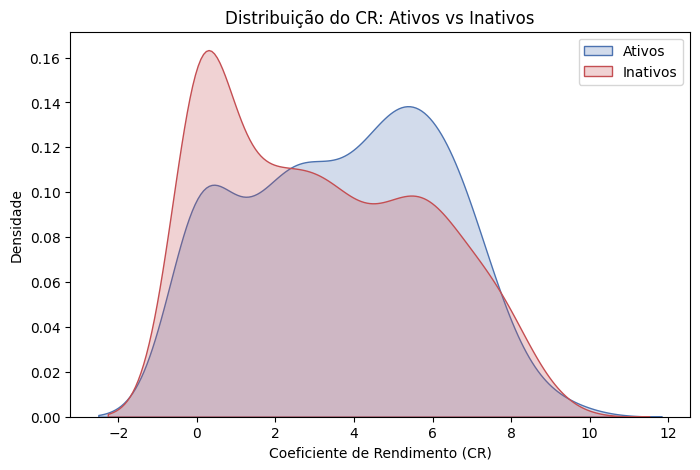


Kolmogorov-Smirnov (Notas por Disciplina: Ativos vs Inativos):
KS = 0.025, p-valor = 0.0172


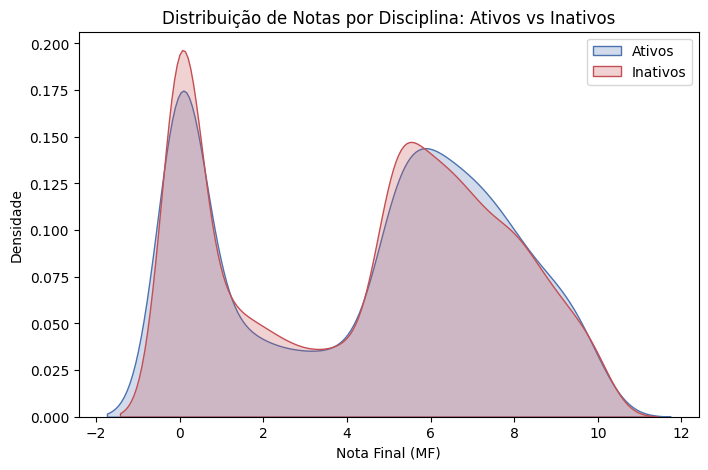

In [43]:
# Separar CR por status
cr_ativos = alunos.loc[alunos["status"]=="ativo", "coeficiente"].dropna()
cr_inativos = alunos.loc[alunos["status"]=="inativo", "coeficiente"].dropna()

# 1️⃣ Mann-Whitney U (diferença de distribuição de CR)
u_stat, p_val = stats.mannwhitneyu(cr_ativos, cr_inativos, alternative='two-sided')
print("Mann-Whitney U (CR Ativos vs Inativos):")
print(f"U = {u_stat:.2f}, p-valor = {p_val:.4f}")

# Visualização CR
plt.figure(figsize=(8,5))
sns.kdeplot(cr_ativos, fill=True, label="Ativos", color="#4C72B0")
sns.kdeplot(cr_inativos, fill=True, label="Inativos", color="#C44E52")
plt.title("Distribuição do CR: Ativos vs Inativos")
plt.xlabel("Coeficiente de Rendimento (CR)")
plt.ylabel("Densidade")
plt.legend()
plt.show()

# 2️⃣ Kolmogorov–Smirnov (K-S) para notas de disciplinas
# Agregar notas MF por aluno e disciplina
notas_ativos = historico.merge(alunos[alunos["status"]=="ativo"][["rga_anonimo"]], on="rga_anonimo")["mf"].dropna()
notas_inativos = historico.merge(alunos[alunos["status"]=="inativo"][["rga_anonimo"]], on="rga_anonimo")["mf"].dropna()

ks_stat, ks_p = stats.ks_2samp(notas_ativos, notas_inativos)
print("\nKolmogorov-Smirnov (Notas por Disciplina: Ativos vs Inativos):")
print(f"KS = {ks_stat:.3f}, p-valor = {ks_p:.4f}")

# Visualização notas
plt.figure(figsize=(8,5))
sns.kdeplot(notas_ativos, fill=True, label="Ativos", color="#4C72B0")
sns.kdeplot(notas_inativos, fill=True, label="Inativos", color="#C44E52")
plt.title("Distribuição de Notas por Disciplina: Ativos vs Inativos")
plt.xlabel("Nota Final (MF)")
plt.ylabel("Densidade")
plt.legend()
plt.show()

### Embora a diferença nas notas não seja grande, ela é consistente o suficiente para ser considerada significativa.
### Ou seja, de maneira geral, os inativos tendem a ter notas ligeiramente diferentes dos ativos, refletindo que desempenho acadêmico pode influenciar a evasão.

## 7. Modelagem estatística


In [49]:
# 1️⃣ Regressão logística
alunos['evadiu'] = (alunos['status'] == 'inativo').astype(int)

# Criar dummies para variáveis categóricas
categorical_vars = ['sexo', 'raca', 'tipo_ingresso']
alunos_model = pd.get_dummies(alunos, columns=categorical_vars, drop_first=True)

# Número de reprovações
reprovacoes_aluno = historico.groupby('rga_anonimo').apply(lambda x: (x['mf'] < 5).sum()).reset_index(name='n_reprovacoes')
alunos_model = alunos_model.merge(reprovacoes_aluno, on='rga_anonimo', how='left')
alunos_model['n_reprovacoes'] = alunos_model['n_reprovacoes'].fillna(0)

# Selecionar X e y
y = alunos_model['evadiu'].astype(float)
X = alunos_model.drop(columns=['status','evadiu','rga_anonimo','data_nascimento','idade','faixa_etaria'])

# Garantir todas as colunas numéricas float
X = X.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

# Adicionar intercepto
X = sm.add_constant(X)

# Ajustar regressão logística
logit_model = sm.Logit(y, X).fit(disp=True)
print(logit_model.summary())

# 2️⃣ Kaplan-Meier
alunos['tempo_curso'] = alunos['periodo'].fillna(0).astype(float)
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,5))

for status in ['ativo', 'inativo']:
    mask = alunos['status'] == status
    kmf.fit(
        durations=alunos.loc[mask, 'tempo_curso'],
        event_observed=(alunos.loc[mask, 'status']=='inativo').astype(int),
        label=status
    )
    kmf.plot_survival_function()

plt.title("Curva de Sobrevivência: Tempo até Evasão")
plt.xlabel("Períodos cursados")
plt.ylabel("Probabilidade de Permanência")
plt.show()

# 3️⃣ Cox Proportional-Hazards
cox_data = alunos_model.copy()
cox_data['duration'] = alunos['tempo_curso']
cox_data['event'] = alunos['evadiu'].astype(float)

# Garantir todas as colunas numéricas
cox_data = cox_data.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

cph = CoxPHFitter()
cph.fit(cox_data, duration_col='duration', event_col='event')
cph.print_summary()

KeyError: "['raca'] not in index"